# Section 02 project

In [26]:
!pip install pdpbox
!pip install shap
!pip install category_encoders
!pip install -U pandas-profiling
!pip install eli5
!pip install xgboost
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelBinarizer, MinMaxScaler
from category_encoders import OneHotEncoder, OrdinalEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from ipywidgets import interact, fixed
import matplotlib.pyplot as plt

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 데이터 선정 및 문제 설정
- '소득이 $50K이 넘는지 예측'하는 것을 문제로 선정해, 소득이 50K이 넘는 사람들이 어떤 특징을 가지고 있는지 파악할 것이다.

## 데이터 불러오기

In [2]:
# 데이터 불러오기
df = pd.read_csv('/content/drive/MyDrive/data/income_train.csv', encoding='cp949')
df.head().T

,0,1,2,3,4
age,67,17,31,58,25
workclass,Private,Private,Private,State-gov,State-gov
fnlwgt,366425,244602,174201,110199,149248
education,Doctorate,12th,Bachelors,7th-8th,Some-college
educational-num,16,8,13,4,10
marital-status,Divorced,Never-married,Married-civ-spouse,Married-civ-spouse,Never-married
occupation,Exec-managerial,Other-service,Exec-managerial,Transport-moving,Other-service
relationship,Not-in-family,Own-child,Husband,Husband,Not-in-family
race,White,White,White,White,Black
gender,Male,Male,Male,Male,Male


## 데이터 전처리 

#### 컬럼 설명

age : 나이

workclass : 고용 형태

fnlwgt : 사람 대표성을 나타내는 가중치 (final weight의 약자)

education : 교육 수준

education_num : 교육 수준 수치

marital_status: 결혼 상태

occupation : 업종

relationship : 가족 관계

race : 인종

sex : 성별

capital_gain : 자본이익

capital_loss : 자본손실

hours_per_week : 주당 근무 시간

native_country : 국적

income : 수익 



In [ ]:
# 컬럼 형태 확인하기
print('df: \n', df.dtypes)

df: 
 age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income_>50K         int64
dtype: object


In [4]:
# 결측치 확인& 중복 확인
print('결측치: \n',df.isna().sum())
print('중복: ', df.duplicated().sum())
df.shape

결측치: 
 age                   0
workclass          2498
fnlwgt                0
education             0
educational-num       0
marital-status        0
occupation         2506
relationship          0
race                  0
gender                0
capital-gain          0
capital-loss          0
hours-per-week        0
native-country      763
income_>50K           0
dtype: int64
중복:  45


(43957, 15)

In [3]:
# 결측치 제거
df.dropna(inplace=True)
print('결측치: \n',df.isna().sum())

결측치: 
 age                0
workclass          0
fnlwgt             0
education          0
educational-num    0
marital-status     0
occupation         0
relationship       0
race               0
gender             0
capital-gain       0
capital-loss       0
hours-per-week     0
native-country     0
income_>50K        0
dtype: int64


In [4]:
# train에서 중복이 확인되었으므로 중복값은 하나만 남기고 제거
df = df.drop_duplicates(keep = 'first')
print('df 중복: ', df.duplicated().sum())

df 중복:  0


## EDA 및 Feature Engineering

In [1]:
# import pandas_profiling
# pandas_profiling.__version__
# pr = df.profile_report() 
# pr

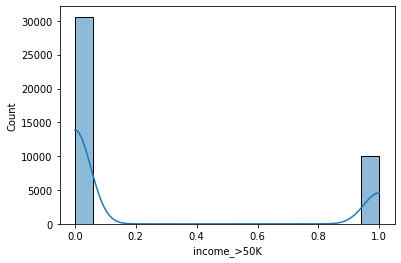

In [7]:
# 타겟변수의 분포도
sns.histplot(df['income_>50K'],kde=True);

In [8]:
# 자본 총합계라는 new column: "total_capital" 생성
def to(df):
  df['capital-loss'] = -df['capital-loss'] # 자본 손실을 음수로 변환
  
  df['total_capital'] = df['capital-gain'] + df['capital-loss']
  return df

df = to(df)

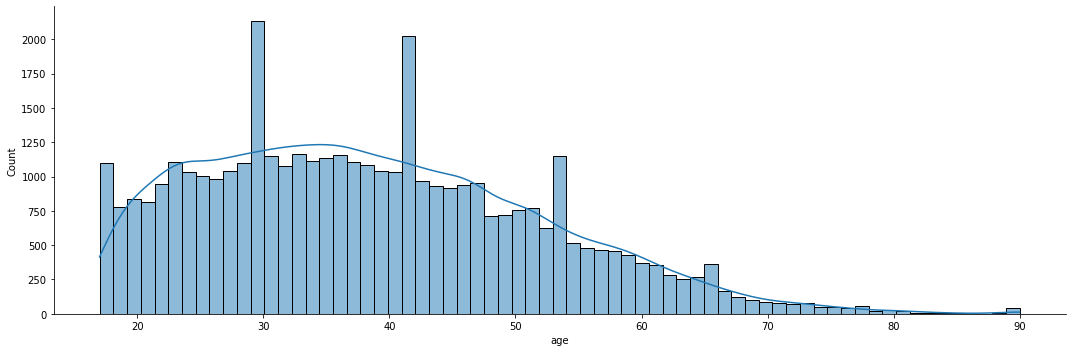

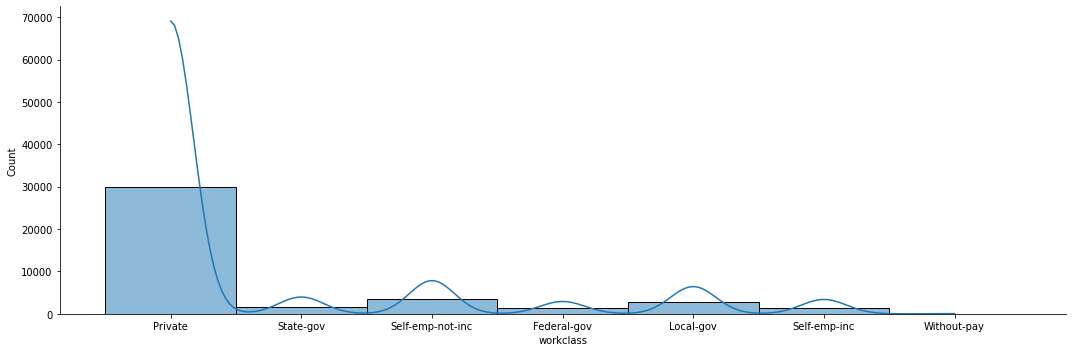

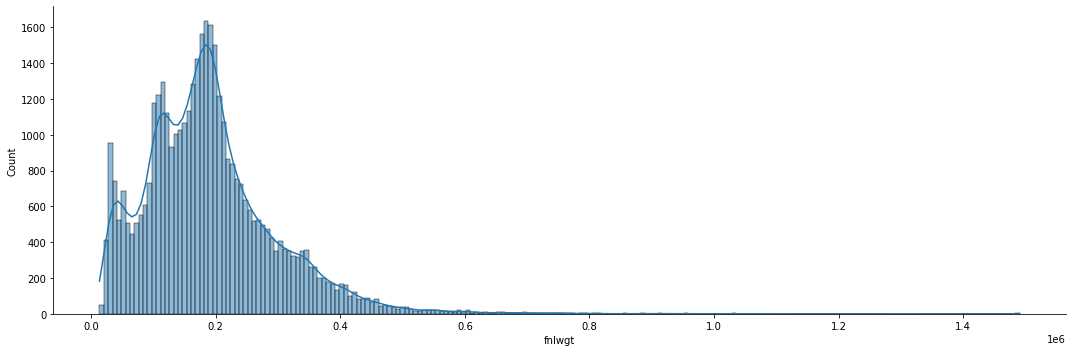

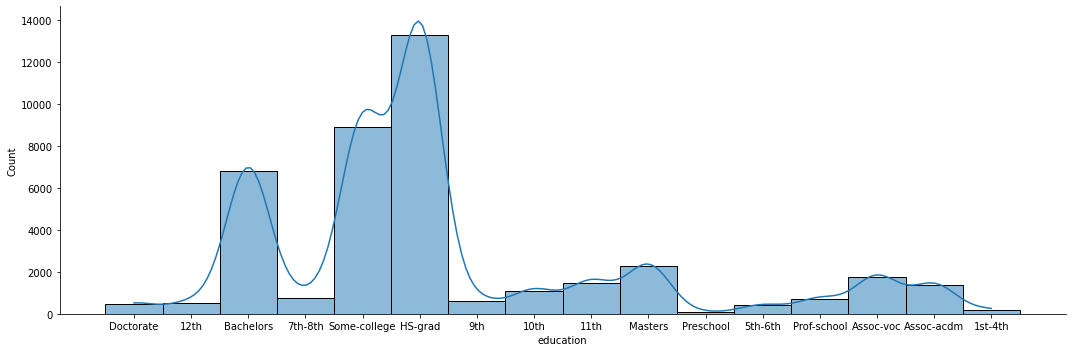

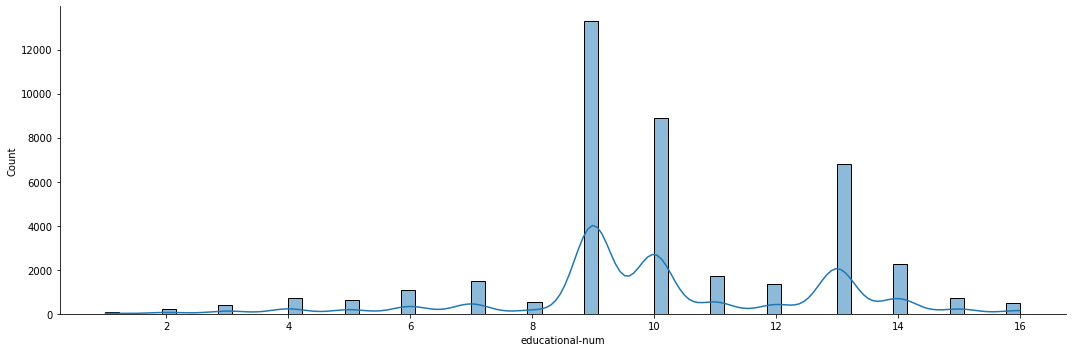

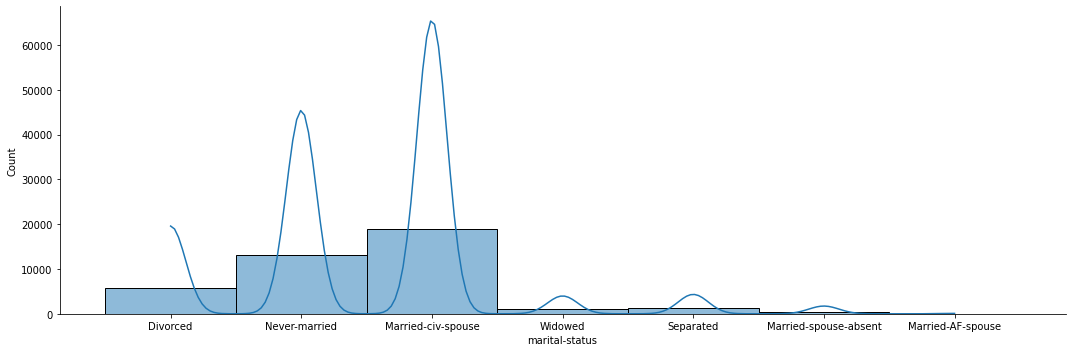

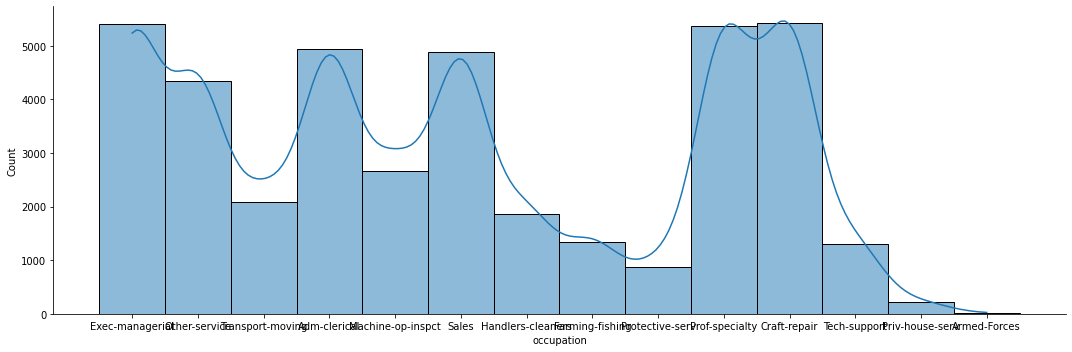

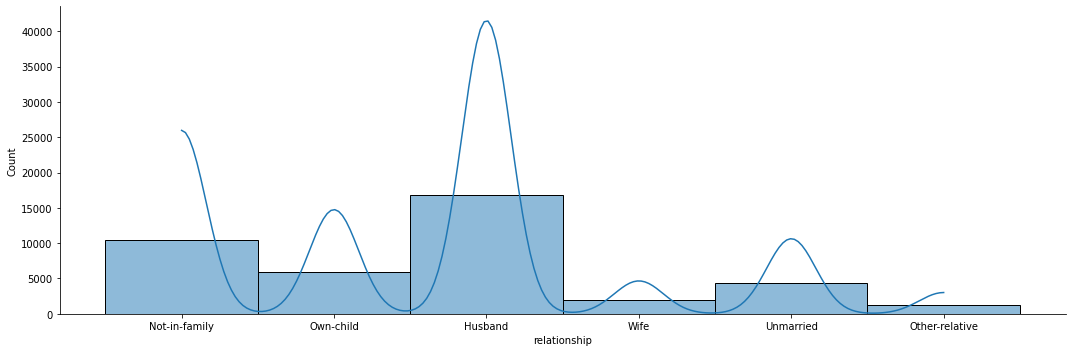

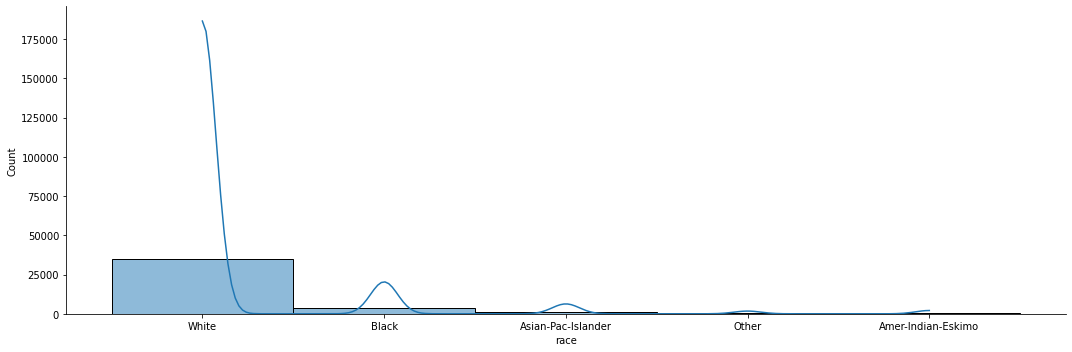

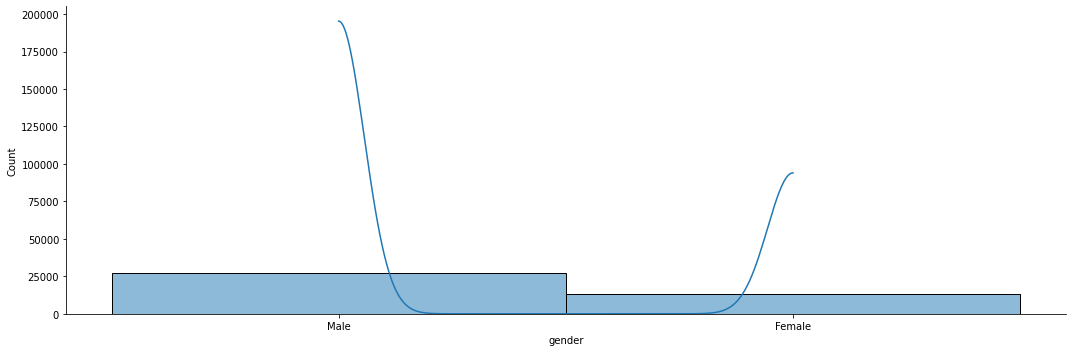

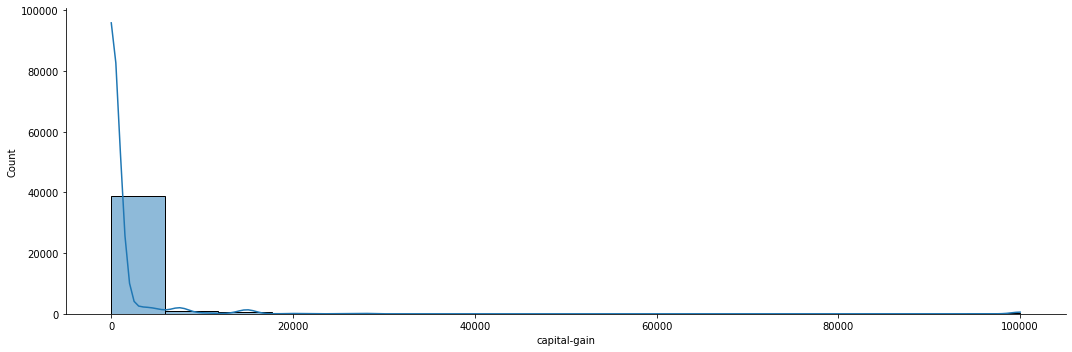

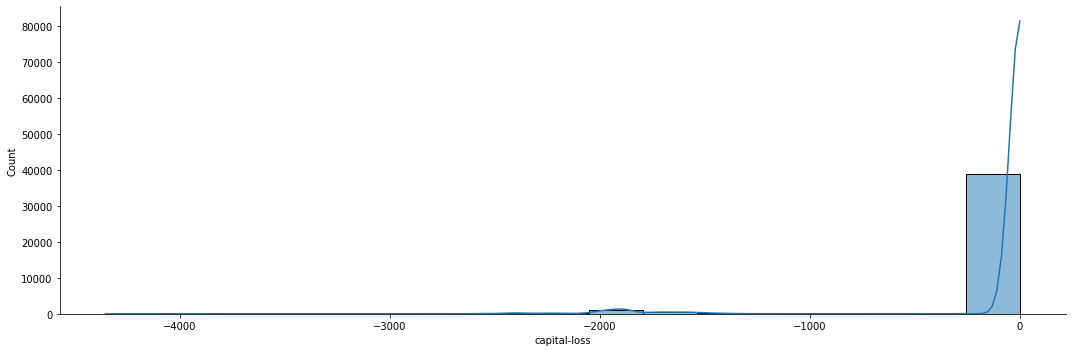

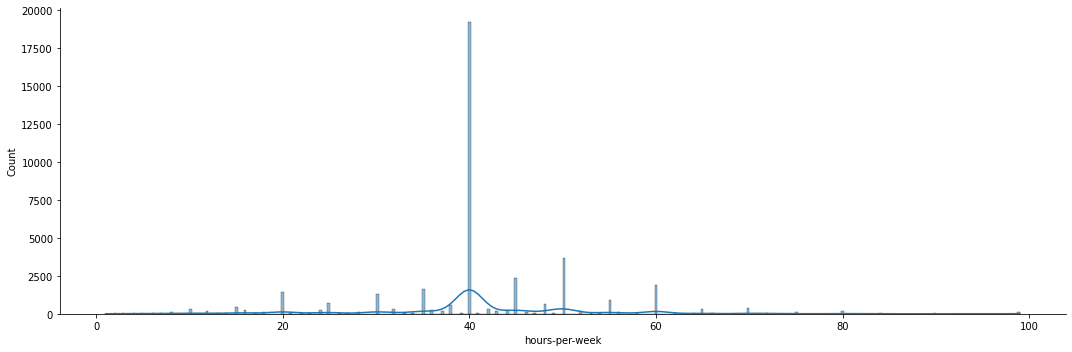

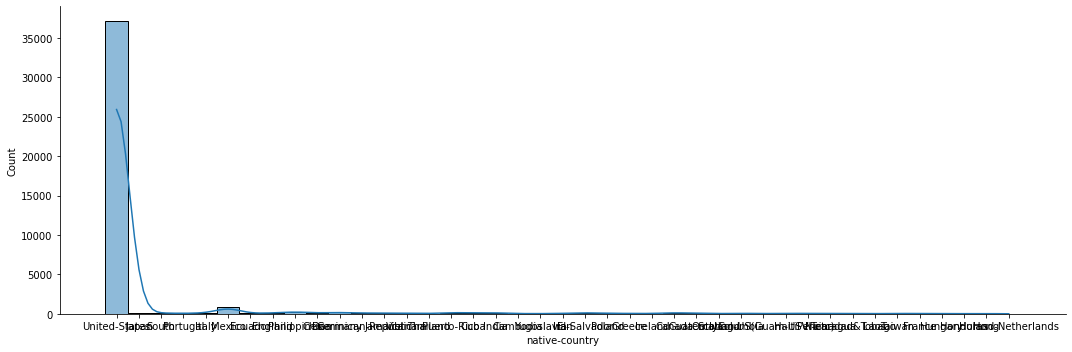

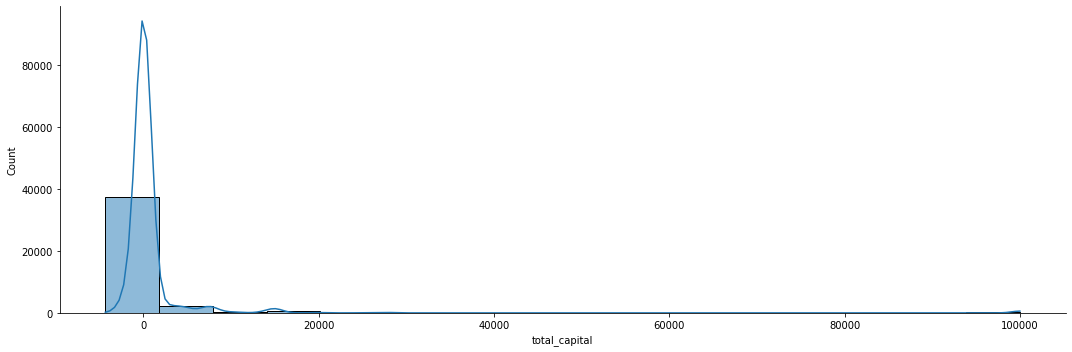

In [9]:
# 각 특성들의 분포 확인
colss = df.drop(['income_>50K'],axis=1).columns
for i in colss:
  sns.displot(df[i], height = 5, aspect = 3, kde=True);

In [10]:
# 특정 컬럼의 카테고리 확인
unicol = df.drop(['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'income_>50K'], axis=1).columns
for i in unicol:
    print(i, df[i].unique())

workclass ['Private' 'State-gov' 'Self-emp-not-inc' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay']
education ['Doctorate' '12th' 'Bachelors' '7th-8th' 'Some-college' 'HS-grad' '9th'
 '10th' '11th' 'Masters' 'Preschool' '5th-6th' 'Prof-school' 'Assoc-voc'
 'Assoc-acdm' '1st-4th']
marital-status ['Divorced' 'Never-married' 'Married-civ-spouse' 'Widowed' 'Separated'
 'Married-spouse-absent' 'Married-AF-spouse']
occupation ['Exec-managerial' 'Other-service' 'Transport-moving' 'Adm-clerical'
 'Machine-op-inspct' 'Sales' 'Handlers-cleaners' 'Farming-fishing'
 'Protective-serv' 'Prof-specialty' 'Craft-repair' 'Tech-support'
 'Priv-house-serv' 'Armed-Forces']
relationship ['Not-in-family' 'Own-child' 'Husband' 'Wife' 'Unmarried' 'Other-relative']
race ['White' 'Black' 'Asian-Pac-Islander' 'Other' 'Amer-Indian-Eskimo']
gender ['Male' 'Female']
native-country ['United-States' 'Japan' 'South' 'Portugal' 'Italy' 'Mexico' 'Ecuador'
 'England' 'Philippines' 'China' 'Germany' 'Dominican-Rep

In [11]:
def cate(df):
  # marital-status 범주 이름 조정
  df = df.replace(['Married-civ-spouse', 'Married-AF-spouse', 'Married-spouse-absent', 'Divorced', 'Never-married', 'Widowed', 'Separated'], 
                  [1, 1, 1, 0, 0, 0, 0])
  
  # education이랑 educational-num이 서로 연관되어 있어 전자를 드랍하기
  df = df.drop('education', axis=1)

  return df

df = cate(df)

In [12]:
df.head().T

,0,1,2,3,4
age,67,17,31,58,25
workclass,Private,Private,Private,State-gov,State-gov
fnlwgt,366425,244602,174201,110199,149248
educational-num,16,8,13,4,10
marital-status,0,0,1,1,0
occupation,Exec-managerial,Other-service,Exec-managerial,Transport-moving,Other-service
relationship,Not-in-family,Own-child,Husband,Husband,Not-in-family
race,White,White,White,White,Black
gender,Male,Male,Male,Male,Male
capital-gain,99999,0,0,0,0


In [13]:
# summary statistics 확인
df.describe()

,age,fnlwgt,educational-num,marital-status,capital-gain,capital-loss,hours-per-week,income_>50K,total_capital
count,40686.000000,4.068600e+04,40686.000000,40686.000000,40686.000000,40686.000000,40686.000000,40686.000000,40686.000000
mean,38.529101,1.897858e+05,10.114585,0.479059,1119.767217,-89.333382,40.912796,0.247923,1030.433835
std,13.240418,1.059153e+05,2.555784,0.499567,7643.607251,406.763825,12.014326,0.431812,7667.480598
min,17.000000,1.349200e+04,1.000000,0.000000,0.000000,-4356.000000,1.000000,0.000000,-4356.000000
25%,28.000000,1.173630e+05,9.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
50%,37.000000,1.782635e+05,10.000000,0.000000,0.000000,0.000000,40.000000,0.000000,0.000000
75%,47.000000,2.380632e+05,13.000000,1.000000,0.000000,0.000000,45.000000,0.000000,0.000000
max,90.000000,1.490400e+06,16.000000,1.000000,99999.000000,0.000000,99.000000,1.000000,99999.000000


## 가설 설정 및 검정
### 1. 가설
가설 1: 주당 근무 시간이 많을수록 소득>$50000일 가능성이 높다.

가설 2: 더  많은 교육을 받은 사람이 소득>$50000일 가능성이 높다.

가설 3: 고용 형태가 소득에 영향을 줄 것이다.(일하지 않는 이는 소득>$50000일 가능성이 낮다.)

### 가설 1: 주당 근무 시간이 많을수록 소득>$50000일 가능성이 높다

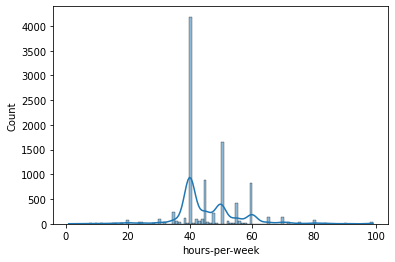

In [14]:
# 가설 1
rich = df[df['income_>50K'] == 1]
sns.histplot(rich['hours-per-week'],kde=True);

- 상단의 분포도를 통해 주당 근무 시간이 많을수록 소득>$50000일 것이라는 귀무가설은 기각할 수 있다.

- 주당 근무시간이 40~60시간인 경우 소득>$50000에 가장 많이 분포되어 있다.


### 가설 2: 더  많은 교육을 받은 사람이 소득>$50000일 가능성이 높다.

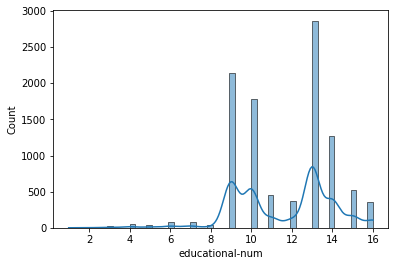

In [15]:
# 가설 2
sns.histplot(rich['educational-num'],kde=True);

- 분포도에서 알 수 있듯, 교육수준이 9~14일 때 소득>$50000인 사람이 가장 많이 분포되어 있다.
- 따라서 가설 2가 어느 정도 받아들여질 수 있다.

### 가설 3: 고용 형태가 소득에 영향을 줄 것이다.(소득이 없는 이는 소득>$50000일 가능성이 낮다.)


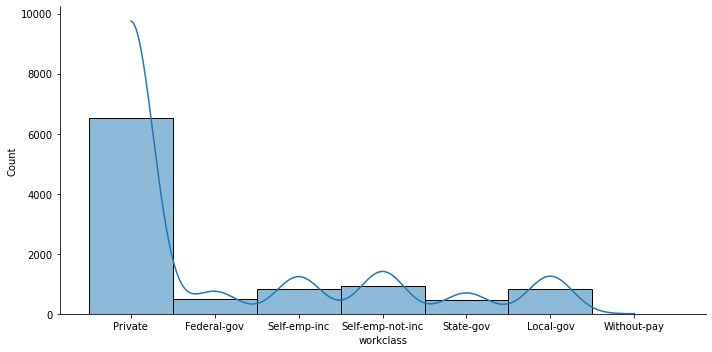

In [16]:
# 가설 3
sns.displot(rich['workclass'], height = 5, aspect = 2,kde=True);

- 상단의 분포를 통해 소득>$50000인 사람은 대부분 어떤 형태로 고용된 이들이며, 일하지 않는 사람을 보여주는 never-worked는 이에 포함되어 있지 않다.

## Baseline model 설정

- 타겟 변수인 delay의 최빈값의 정확도 0.760589로 설정하였다.

In [17]:
# baseline
df['income_>50K'].value_counts(normalize=True) 

0    0.752077
1    0.247923
Name: income_>50K, dtype: float64

In [18]:
# 불균형 클래스 가중치 
ratio = 0.752077/0.247923

## 모델 학습
### 데이터셋 분할


In [19]:
target = 'income_>50K'
feature = df.drop(columns=[target]).columns

# test/train/val으로 데이터셋 구분하기
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, random_state=2)
train, val = train_test_split(train, random_state=2)

# 훈련세트-독립/종속변수 지정 + 테스트세트-독립/종속변수 지정
X_train = train[feature]
y_train = train[target]
X_test = test[feature]
y_test = test[target]
X_val = val[feature]
y_val = val[target]

In [20]:
train.shape, val.shape, test.shape

((22885, 15), (7629, 15), (10172, 15))


### 1차 model: `Logistic Regression`

In [21]:
# 1차 기본모델: logistic regression
from sklearn.linear_model import LogisticRegression
log = make_pipeline( 
    OrdinalEncoder(),
    SimpleImputer(),
    LogisticRegression()
)

log.fit(X_train, y_train)
y_pred = log.predict(X_val)
print('훈련 정확도', log.score(X_train, y_train))
print('검증 정확도', log.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

훈련 정확도 0.7967664409001529
검증 정확도 0.7913225848735089
Report 
               precision    recall  f1-score   support

           0       0.80      0.97      0.87      5718
           1       0.73      0.27      0.39      1911

    accuracy                           0.79      7629
   macro avg       0.76      0.62      0.63      7629
weighted avg       0.78      0.79      0.75      7629

f1 스코어 0.3919022154316272
auc점수 :  0.6172589465199269


- logistic regression 모델은 타겟=0과 타겟=1의 f1 스코어의 차이가 크기 때문에 적합하지 않다.


### 1차 model: `Random Forest`

In [22]:
# 1차 기본모델: RF
pipe = make_pipeline( 
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, class_weight = 'balanced', random_state=2)
)

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_val)
print('훈련 정확도', pipe.score(X_train, y_train))
print('검증 정확도', pipe.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_pred))
print('f1 스코어',f1_score(y_val, y_pred))
print('auc점수 : ', roc_auc_score(y_val, y_pred))

훈련 정확도 1.0
검증 정확도 0.8547647135928693
Report 
               precision    recall  f1-score   support

           0       0.88      0.94      0.91      5718
           1       0.76      0.61      0.68      1911

    accuracy                           0.85      7629
   macro avg       0.82      0.77      0.79      7629
weighted avg       0.85      0.85      0.85      7629

f1 스코어 0.679212507237985
auc점수 :  0.7745534084163974


- RF 모델에서는 전 모델에 비해 상대적으로 타겟이 0, 1일 때의 f1 스코어의 차이가 줄었지만 훈련 정확도와 검증 정확도의 값 간의 차이가 다소 존재해 과적합을 의심해볼 수 있다.


### 1차 model: `Catboost` 

In [24]:
# 1차 기본모델: catboost
from catboost import CatBoostClassifier

pipe_cat = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    CatBoostClassifier(scale_pos_weight=ratio, random_state=2))

pipe_cat.fit(X_train, y_train)
y_predc = pipe_cat.predict(X_val)
print('훈련 정확도', pipe_cat.score(X_train, y_train))
print('검증 정확도', pipe_cat.score(X_val, y_val))
print('Report \n',classification_report(y_val, y_predc))
print('f1 스코어',f1_score(y_val, y_predc))
print('auc점수 : ', roc_auc_score(y_val, y_predc))

Learning rate set to 0.039216
0:	learn: 0.6638642	total: 59.2ms	remaining: 59.1s
1:	learn: 0.6385457	total: 78ms	remaining: 38.9s
2:	learn: 0.6141264	total: 93.9ms	remaining: 31.2s
3:	learn: 0.5924599	total: 107ms	remaining: 26.5s
4:	learn: 0.5744012	total: 121ms	remaining: 24.1s
5:	learn: 0.5581008	total: 143ms	remaining: 23.6s
6:	learn: 0.5440804	total: 149ms	remaining: 21.1s
7:	learn: 0.5322902	total: 155ms	remaining: 19.2s
8:	learn: 0.5205974	total: 161ms	remaining: 17.8s
9:	learn: 0.5075603	total: 168ms	remaining: 16.6s
10:	learn: 0.4963241	total: 175ms	remaining: 15.7s
11:	learn: 0.4866846	total: 181ms	remaining: 14.9s
12:	learn: 0.4784438	total: 192ms	remaining: 14.6s
13:	learn: 0.4721736	total: 199ms	remaining: 14s
14:	learn: 0.4658256	total: 206ms	remaining: 13.5s
15:	learn: 0.4591296	total: 212ms	remaining: 13s
16:	learn: 0.4539825	total: 219ms	remaining: 12.7s
17:	learn: 0.4495675	total: 226ms	remaining: 12.3s
18:	learn: 0.4451080	total: 233ms	remaining: 12s
19:	learn: 0.440

- catboost 모델은 전 모델들에 비해 타겟의 값에 따른 f1 스코어와 모델의 f1 스코어, auc 점수 모두 가장 높다는 것을 확인할 수 있었다.
- 2차 모델 학습에서는 XGBoost, Catboost 모델을 하이퍼파라미터 튜닝을 통해 성능을 높일 것이다.

## 2. 하이퍼파라미터를 조정한 모델 학습
### 2-1. `Catboost`

In [27]:
pipe_cat = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    CatBoostClassifier(scale_pos_weight=ratio, random_state=2)
)

distscat = {
    'ordinalencoder__handle_missing': ['value'],
    'simpleimputer__strategy': ['mean', 'median'], 
    'catboostclassifier__learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.05, 0.4], 
    'catboostclassifier__max_depth': randint(0, 10),
    'catboostclassifier__n_estimators': randint(50, 500)
}

clf = RandomizedSearchCV(
    pipe_cat, 
    param_distributions=distscat, 
    n_iter=30, 
    cv=3,
    scoring='f1',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 30 candidates, totalling 90 fits
0:	learn: 0.6230042	total: 7.59ms	remaining: 3.73s
1:	learn: 0.5724090	total: 14.9ms	remaining: 3.66s
2:	learn: 0.5321847	total: 21.4ms	remaining: 3.5s
3:	learn: 0.5008401	total: 28.1ms	remaining: 3.43s
4:	learn: 0.4793425	total: 34.9ms	remaining: 3.41s
5:	learn: 0.4599523	total: 41.7ms	remaining: 3.38s
6:	learn: 0.4465130	total: 48.3ms	remaining: 3.35s
7:	learn: 0.4358932	total: 55.3ms	remaining: 3.35s
8:	learn: 0.4276154	total: 62ms	remaining: 3.34s
9:	learn: 0.4203522	total: 69.2ms	remaining: 3.34s
10:	learn: 0.4142872	total: 81ms	remaining: 3.55s
11:	learn: 0.4104912	total: 92ms	remaining: 3.69s
12:	learn: 0.4066840	total: 98.4ms	remaining: 3.63s
13:	learn: 0.4030286	total: 105ms	remaining: 3.6s
14:	learn: 0.3998907	total: 112ms	remaining: 3.58s
15:	learn: 0.3971100	total: 119ms	remaining: 3.55s
16:	learn: 0.3948852	total: 126ms	remaining: 3.52s
17:	learn: 0.3928447	total: 133ms	remaining: 3.5s
18:	learn: 0.3901371	total:

In [28]:
print('최적 하이퍼파라미터: ', clf.best_params_)

최적 하이퍼파라미터:  {'catboostclassifier__learning_rate': 0.1, 'catboostclassifier__max_depth': 6, 'catboostclassifier__n_estimators': 493, 'ordinalencoder__handle_missing': 'value', 'simpleimputer__strategy': 'mean'}


In [29]:
pipe_ca = clf.best_estimator_
y_val_predca = pipe_ca.predict(X_val)
y_train_predca = pipe_ca.predict(X_train)
print('훈련 f1 score: ', f1_score(y_train, y_train_predca))
print('검증 f1 score: ', f1_score(y_val, y_val_predca))
print('Report \n',classification_report(y_val, y_val_predca))
print('auc점수 : ', roc_auc_score(y_val, y_val_predca))

훈련 f1 score:  0.7790021426385063
검증 f1 score:  0.7227004984141367
Report 
               precision    recall  f1-score   support

           0       0.94      0.84      0.89      5718
           1       0.64      0.83      0.72      1911

    accuracy                           0.84      7629
   macro avg       0.79      0.84      0.80      7629
weighted avg       0.86      0.84      0.85      7629

auc점수 :  0.8379223834178113


- 1차모델보다 auc 스코어, f1 score 모두 높고, 과적합의 가능성 또한 낮으므로 2차 학습한 `Catboost` 모델을 최종 모델로 선택한다.

### 2-2. ROC curve & AUC score

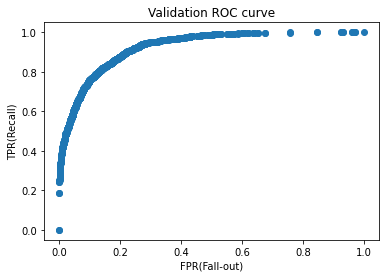

In [30]:
from sklearn.metrics import roc_curve

y_pred_proba = pipe_ca.predict_proba(X_val)[:, 1]

# roc_curve(타겟값, prob of 1)
fprv, tprv, thresholdsv = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fprv, 
    'TPRate(Recall)': tprv, 
    'Threshold': thresholdsv
})

plt.scatter(fprv, tprv)
plt.title('Validation ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

idx: 1059 , threshold: 0.37478910754021555


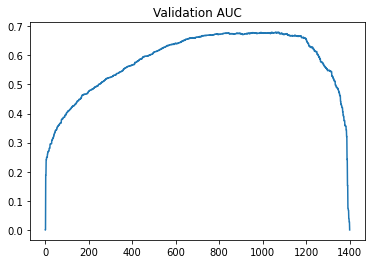

In [31]:
# 최적의 threshold & AUC
optimal_idxv = np.argmax(tprv - fprv)
optimal_thresholdv = thresholdsv[optimal_idxv]

print('idx:', optimal_idxv, ', threshold:', optimal_thresholdv)
plt.title('Validation AUC')
plt.plot(tprv-fprv);

In [32]:
# threshold 설정 및 레포트
y_v_pred_optimal = y_pred_proba >= optimal_thresholdv
print('Report \n',classification_report(y_val, y_v_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_v_pred_optimal)
print('검정 정확도', pipe_ca.score(X_val, y_val))
print('val_f1 스코어',f1_score(y_val, y_v_pred_optimal))
print('val_auc점수 : ', auc_score)

Report 
               precision    recall  f1-score   support

           0       0.96      0.78      0.86      5718
           1       0.58      0.90      0.70      1911

    accuracy                           0.81      7629
   macro avg       0.77      0.84      0.78      7629
weighted avg       0.86      0.81      0.82      7629

검정 정확도 0.8395595753047581
val_f1 스코어 0.7030451665644798
val_auc점수 :  0.8396728939376219


## 최종 테스트 성능 평가

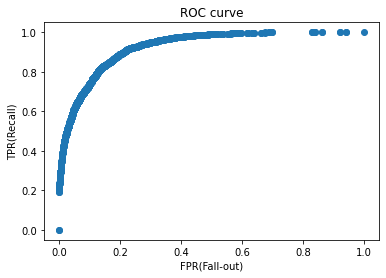

In [33]:
# 테스트 데이터 모델에 넣어서 roc curve
y_test_pred_proba = pipe_ca.predict_proba(X_test)[:, 1]

# roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

idx: 1389 , test_threshold: 0.421078416524647


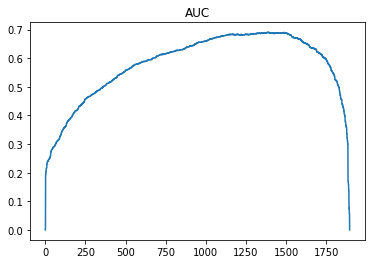

In [34]:
# 최적의 threshold & AUC
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

print('idx:', optimal_idx, ', test_threshold:', optimal_threshold)
plt.title('AUC')
plt.plot(tpr-fpr);

In [35]:
# threshold 설정 및 레포트
y_test_pred_optimal = y_test_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_test, y_test_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_test, y_test_pred_optimal)
print('테스트 정확도', pipe_ca.score(X_test, y_test))
print('test_f1 스코어',f1_score(y_test, y_test_pred_optimal))
print('test_auc점수 : ', auc_score)

Report 
               precision    recall  f1-score   support

           0       0.95      0.80      0.87      7545
           1       0.61      0.89      0.72      2627

    accuracy                           0.82     10172
   macro avg       0.78      0.85      0.80     10172
weighted avg       0.86      0.82      0.83     10172

테스트 정확도 0.8394612662209988
test_f1 스코어 0.7235759739251901
test_auc점수 :  0.8452524290874472


## 분석 및 결론
### 1. 특성 중요도 & 순열 중요도

0:	learn: 0.5883565	total: 6.27ms	remaining: 1.92s
1:	learn: 0.5286450	total: 12.3ms	remaining: 1.88s
2:	learn: 0.4806876	total: 17.7ms	remaining: 1.8s
3:	learn: 0.4530558	total: 23.6ms	remaining: 1.79s
4:	learn: 0.4371177	total: 29.6ms	remaining: 1.8s
5:	learn: 0.4287347	total: 35.4ms	remaining: 1.78s
6:	learn: 0.4211998	total: 40.9ms	remaining: 1.76s
7:	learn: 0.4150904	total: 46.5ms	remaining: 1.74s
8:	learn: 0.4108294	total: 52.4ms	remaining: 1.74s
9:	learn: 0.4073468	total: 58.2ms	remaining: 1.73s
10:	learn: 0.4029716	total: 64.1ms	remaining: 1.73s
11:	learn: 0.3992464	total: 69.7ms	remaining: 1.72s
12:	learn: 0.3961288	total: 75.3ms	remaining: 1.71s
13:	learn: 0.3939351	total: 80.9ms	remaining: 1.7s
14:	learn: 0.3907164	total: 86ms	remaining: 1.68s
15:	learn: 0.3887329	total: 91.6ms	remaining: 1.67s
16:	learn: 0.3869777	total: 97.3ms	remaining: 1.67s
17:	learn: 0.3856231	total: 103ms	remaining: 1.66s
18:	learn: 0.3833571	total: 109ms	remaining: 1.66s
19:	learn: 0.3822809	total: 1

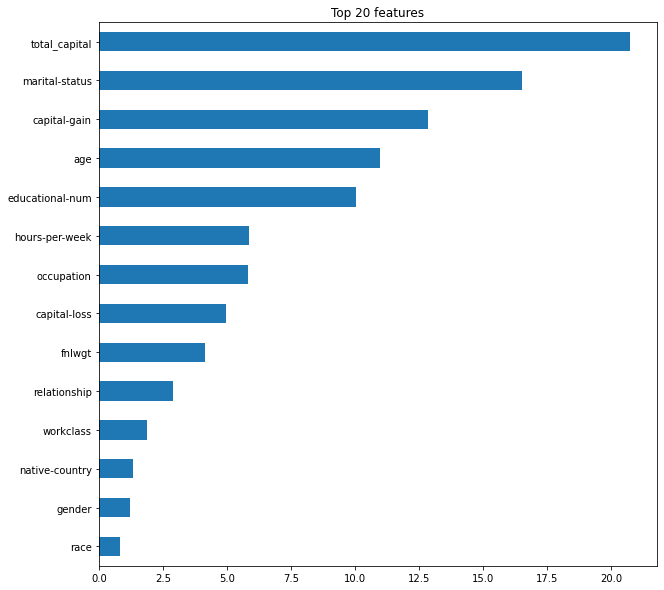

In [36]:
# feature importance
processor = make_pipeline(
    OrdinalEncoder(handle_missing='value'), 
    SimpleImputer(strategy='mean')
)
X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

model = CatBoostClassifier(learning_rate=0.2, max_depth= 4, n_estimators=308, 
                           scale_pos_weight=ratio, random_state=2).fit(X_train_processed, y_train)

importances = pd.Series(model.feature_importances_, X_train.columns)

%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh();

In [39]:
# permutation importance
permuter = PermutationImportance(model, 
    scoring='f1', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
).fit(X_val_processed, y_val)

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

race              -0.001530
native-country     0.001914
fnlwgt             0.002029
workclass          0.004713
capital-loss       0.008691
occupation         0.014004
hours-per-week     0.015994
relationship       0.018030
gender             0.019383
total_capital      0.032142
capital-gain       0.036678
age                0.041880
educational-num    0.042649
marital-status     0.065737
dtype: float64

In [40]:
import eli5
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0657 ± 0.0033,marital-status
0.0426 ± 0.0028,educational-num
0.0419 ± 0.0081,age
0.0367 ± 0.0044,capital-gain
0.0321 ± 0.0048,total_capital
0.0194 ± 0.0077,gender
0.0180 ± 0.0045,relationship
0.0160 ± 0.0078,hours-per-week
0.0140 ± 0.0045,occupation
0.0087 ± 0.0019,capital-loss


## 2. PDP
- 순열중요도가 높은 5개의 PDP 확인해 타겟 변수와 어떤 상관관계를 가지고 있는지 확인할 것이다.

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


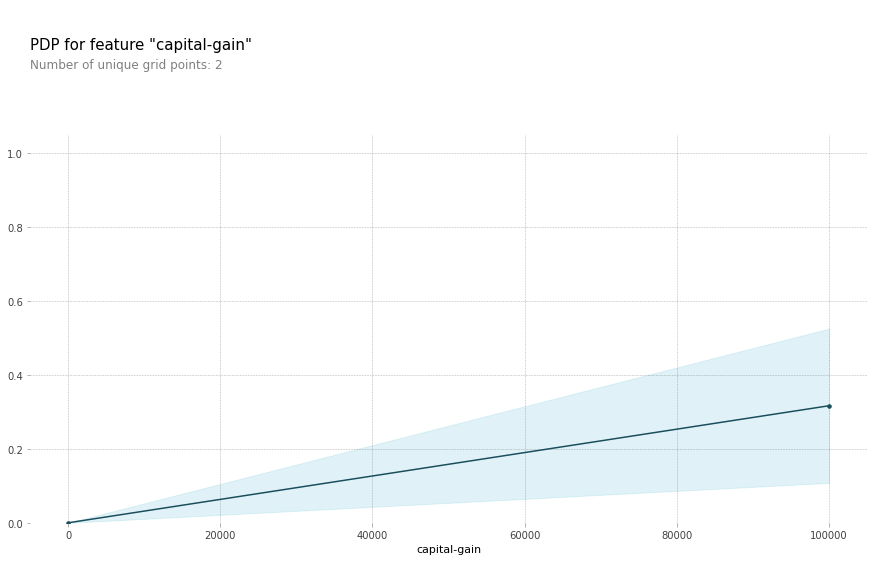

In [41]:
# Partial Dependence Plot: capital-gain
encoder = OrdinalEncoder(handle_missing='value')
X_train_encoded = encoder.fit_transform(X_train)

from pdpbox import pdp
feature = 'capital-gain'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=X_train_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

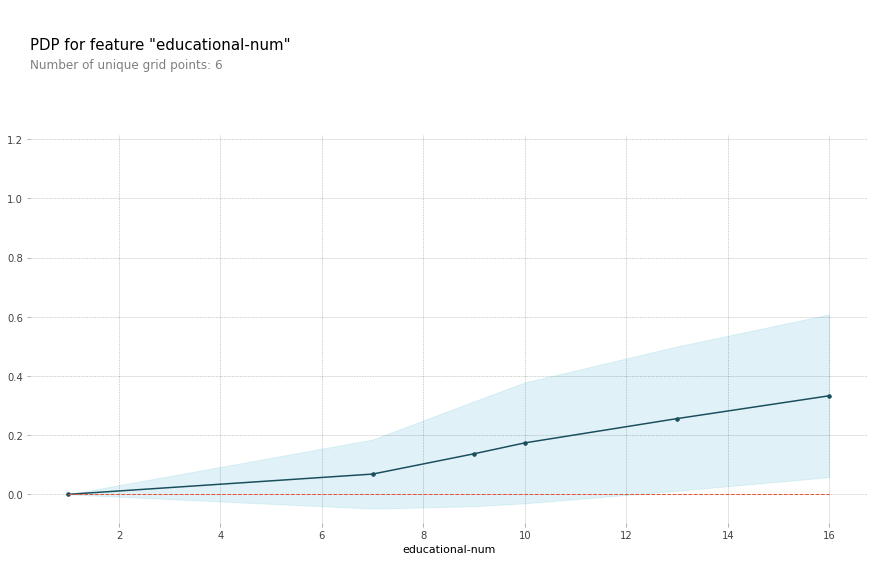

In [42]:
# Partial Dependence Plot: educational-num
feature = 'educational-num'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=X_train_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

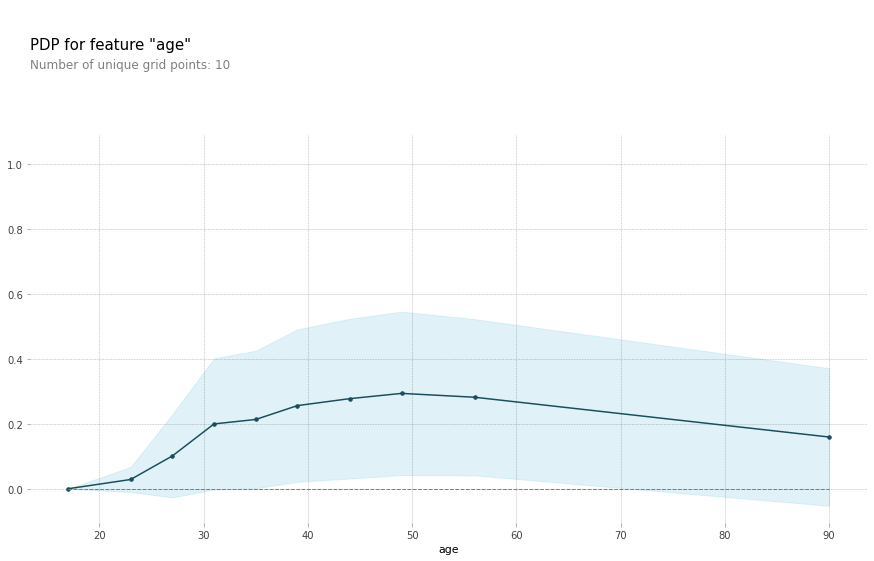

In [43]:
# Partial Dependence Plot: age
feature = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=X_train_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

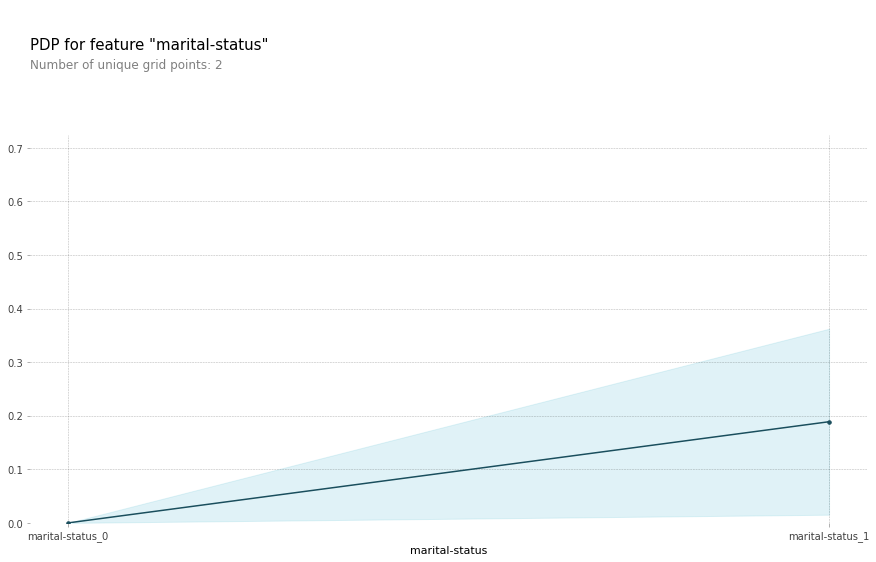

In [44]:
# Partial Dependence Plot: marital-status
feature = 'marital-status'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=X_train_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

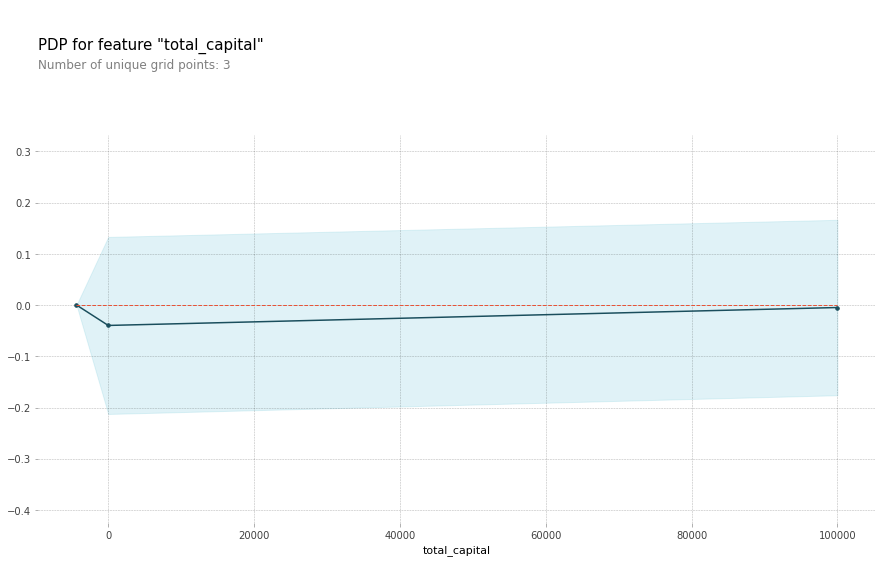

In [45]:
# Partial Dependence Plot: total_capital
feature = 'total_capital'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_encoded, model_features=X_train_encoded.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature); 

In [46]:
# Shap force plot
import json
import sklearn
import shap

explainer = shap.TreeExplainer(model)
row = X_test.iloc[:100]
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_test)

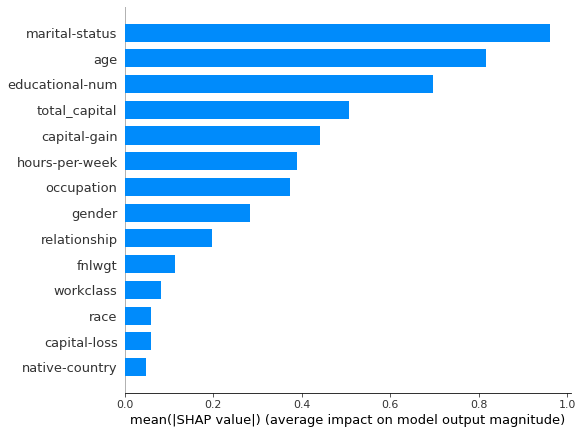

In [47]:
# Shap summary plot
shap.summary_plot(shap_values, X_test.iloc[:100], plot_type="bar")

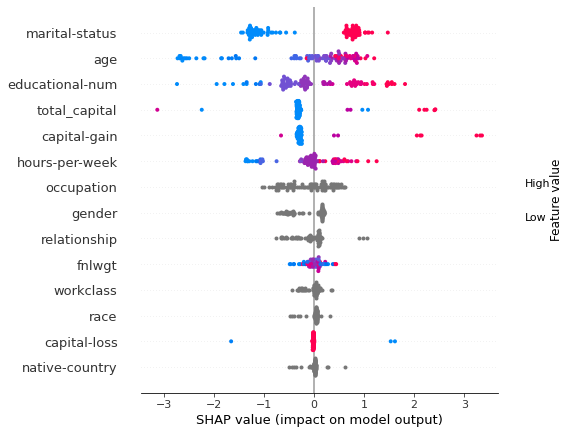

In [48]:
shap.summary_plot(shap_values, X_test.iloc[:100])

### 👉🏼 정리
- positive/negative를 떠나 타겟 변수가 가장 크게 영향을 주는 특성은 `marital status`, `age`, `educational-num`, `total capital` 순임
- `결혼 관계(marital status)`, `나이(age)`, `교육수준(eduacational-num)`, `자본총합계(total capital)`, `자본이익(capital-gain)`은 특성값이 작을수록 타겟에 negative한 영향을 주고, 특성값이 클수록 positive한 영향을 줌